# 导入必要的库

我们需要导入一个叫 [captcha](https://github.com/lepture/captcha/) 的库来生成验证码。

我们生成验证码的字符由数字和大写字母组成。

In [22]:

import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
characters = string.digits +  "ABCDEFGHJKLMNOPQRSTUVWXYZabdefghijlnqrty"
print(characters,len(characters))

width, height, n_len, n_class = 120, 36, 4, len(characters)

0123456789ABCDEFGHJKLMNOPQRSTUVWXYZabdefghijlnqrty 50


# 定义数据生成器

In [23]:
import requests
from PIL import Image as pilImage
from PIL import  ImageEnhance,ImageFilter
from io import BytesIO
import time
 
host="http://192.168.128.128:8080"
url = host+"/make_captcha.php?code=1234&width=120&height=36"
requests.get(url)
reuse_session = requests.session()

def get_img(code):
    url = host+"/make_captcha.php?code="+code+"&width=120&height=36"
    while True:
        content = reuse_session.get(url)
        if content.status_code != 200:
            time.sleep(1)
            print("get captcha from:%s res:%d"%(url, content.status_code))
            continue
        break
    return content.content


 
thread_hold = 600
def is_white(color):
    #print(color)
    return color > thread_hold
def depoint(img):   #input: gray image
    pixdata = img.load()
    w,h = img.size
    for y in range(1,h-2):
        last_color = sum(pixdata[0,y])
        next_color = sum(pixdata[1,y])

        for x in range(1,w-2):
            up_color  = sum(pixdata[x,y - 1])
            down_color = sum(pixdata[x, y + 1])
            color = next_color
            next_color = sum(pixdata[x+1,y])
            if is_white(color):
                pixdata[x,y]=(255,255,255)
            else:
                if is_white(last_color) and is_white(next_color) or is_white(up_color) and is_white(down_color):
                    pixdata[x,y] = (255,255,255)
            last_color = color
    return img

def gen(batch_size=32, show_img=False):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    while True:
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(4)])
            while True:
                try:
                    img1 = pilImage.open(BytesIO(get_img(random_str)))
                    #img = gray_image(img)
                    if show_img:
                        plt.imshow(img1)
                        #plt.title(decode(y,i))
                        plt.show()
                    img = depoint(img1)
                    #print(img)
                    #img=img.convert("RGB")
                except Exception as e:
                    print(e)
                    continue
                break
            #print(img)
            X[i] = img
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, characters.find(ch)] = 1
        yield X,y


# 测试生成器

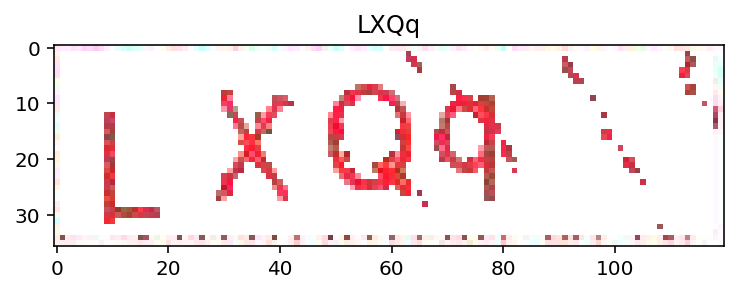

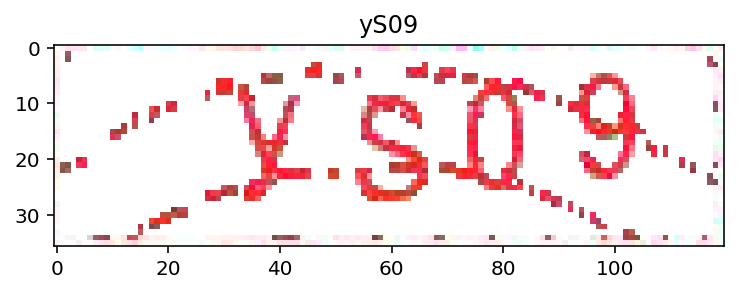

In [24]:
num=2
genImg=gen(num)
def decode(y,i):
    y = np.argmax(np.array(y), axis=2)[:,i]
    return ''.join([characters[x] for x in y])
X, y = next(genImg)
for i in range (num):
    plt.imshow(X[i])
    plt.title(decode(y,i))
    plt.show()
    #print(y)
   # print(X[i])

# 定义网络结构

In [26]:
# CNN
from keras.models import *
from keras.layers import *

input_tensor = Input((height, width, 3))
x = input_tensor
#print(x)
for i in range(3):
    x = Conv2D(32*2**i, (3, 5), activation='relu', data_format='channels_last')(x)
    x = Conv2D(32*2**i, (3, 5), activation='relu', data_format='channels_last')(x)
    x = MaxPooling2D((2, 2), data_format='channels_last')(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(4)]
model = Model(inputs=input_tensor, outputs=x)

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

# 网络结构可视化

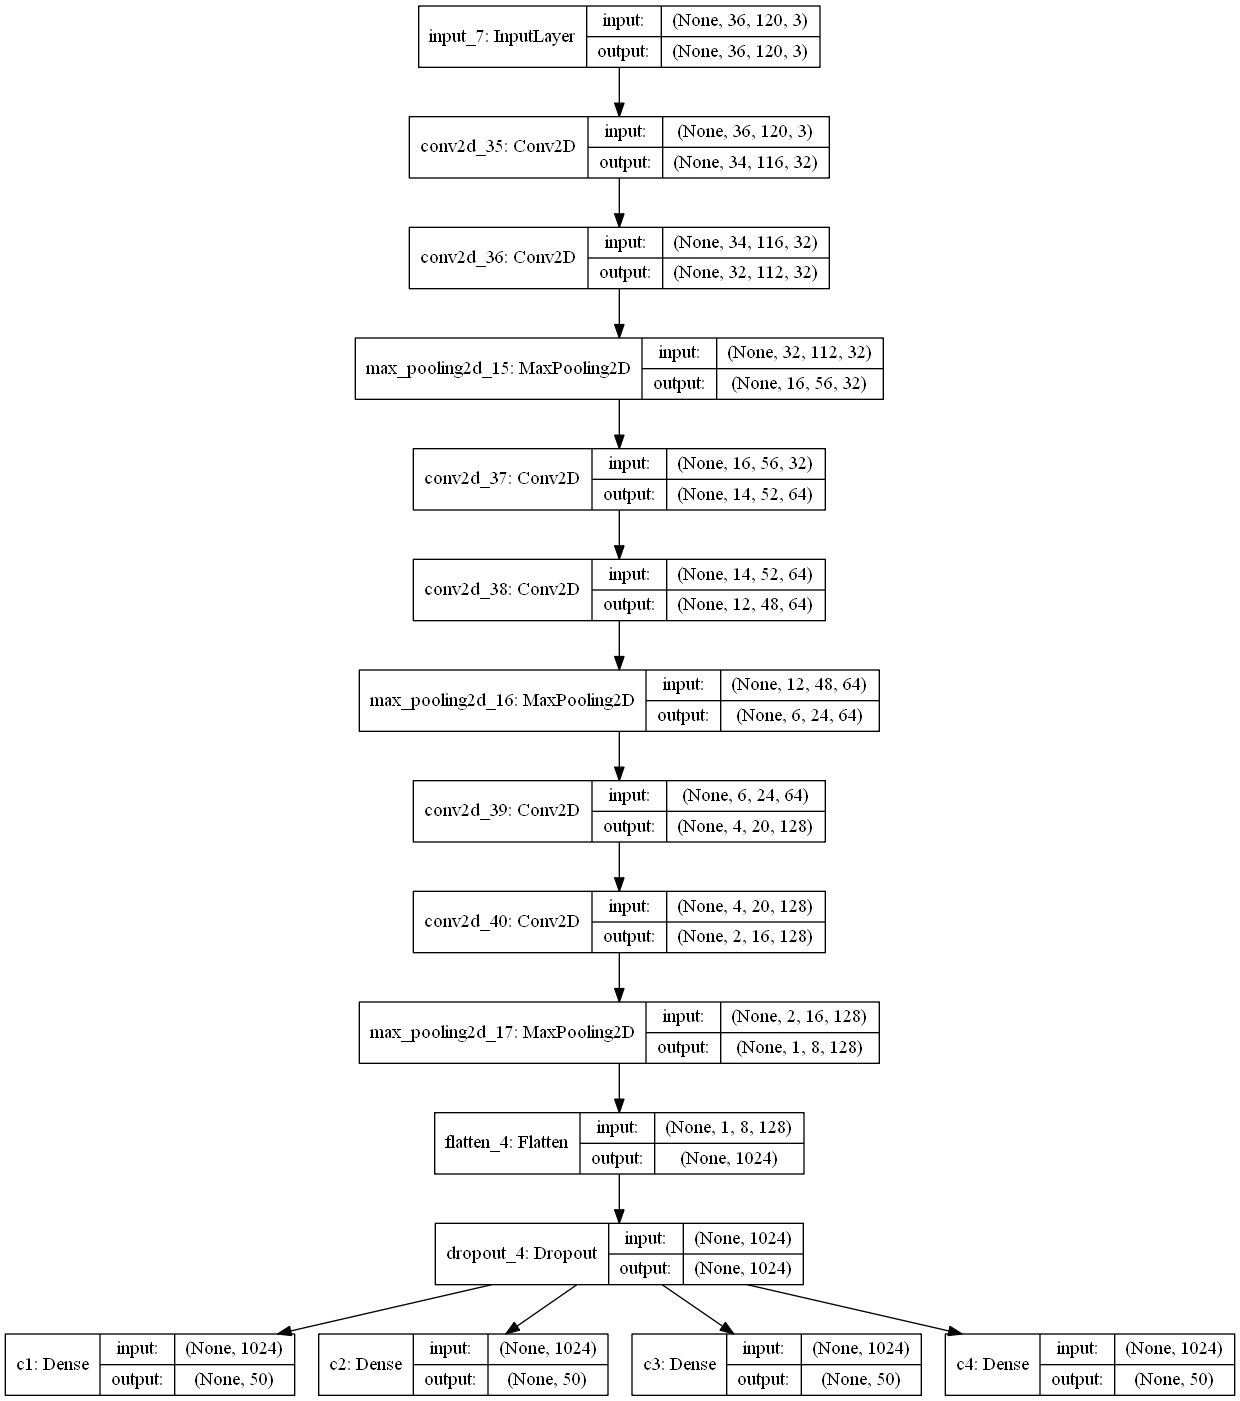

In [27]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image

plot_model(model, to_file="model.png", show_shapes=True)
Image('model.png')

# 训练模型

In [28]:
model.fit_generator(gen(128), steps_per_epoch=500, epochs=10,
                    validation_data=gen(), validation_steps=1280)

Epoch 1/10
500/500 [==============================] - 1053s 2s/step - loss: 16.3187 - c1_loss: 4.0781 - c2_loss: 4.0877 - c3_loss: 4.0871 - c4_loss: 4.0658 - c1_acc: 0.0403 - c2_acc: 0.0402 - c3_acc: 0.0393 - c4_acc: 0.0435 - val_loss: 13.9432 - val_c1_loss: 3.5015 - val_c2_loss: 3.4979 - val_c3_loss: 3.4921 - val_c4_loss: 3.4517 - val_c1_acc: 0.1079 - val_c2_acc: 0.0985 - val_c3_acc: 0.0988 - val_c4_acc: 0.1122
Epoch 2/10
500/500 [==============================] - 1041s 2s/step - loss: 11.4183 - c1_loss: 2.8220 - c2_loss: 2.8520 - c3_loss: 2.8735 - c4_loss: 2.8708 - c1_acc: 0.2468 - c2_acc: 0.2078 - c3_acc: 0.2078 - c4_acc: 0.2360 - val_loss: 7.8561 - val_c1_loss: 1.9639 - val_c2_loss: 1.9191 - val_c3_loss: 1.9154 - val_c4_loss: 2.0578 - val_c1_acc: 0.4678 - val_c2_acc: 0.3983 - val_c3_acc: 0.4043 - val_c4_acc: 0.4406
Epoch 3/10
500/500 [==============================] - 1041s 2s/step - loss: 6.4238 - c1_loss: 1.6650 - c2_loss: 1.5221 - c3_loss: 1.4984 - c4_loss: 1.7383 - c1_acc: 0.54

# 测试模型

In [30]:
genImg1=gen(1, True)


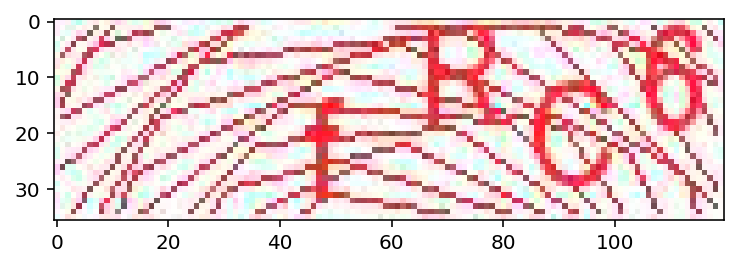

(0.0, 1.0, 0.0, 1.0)

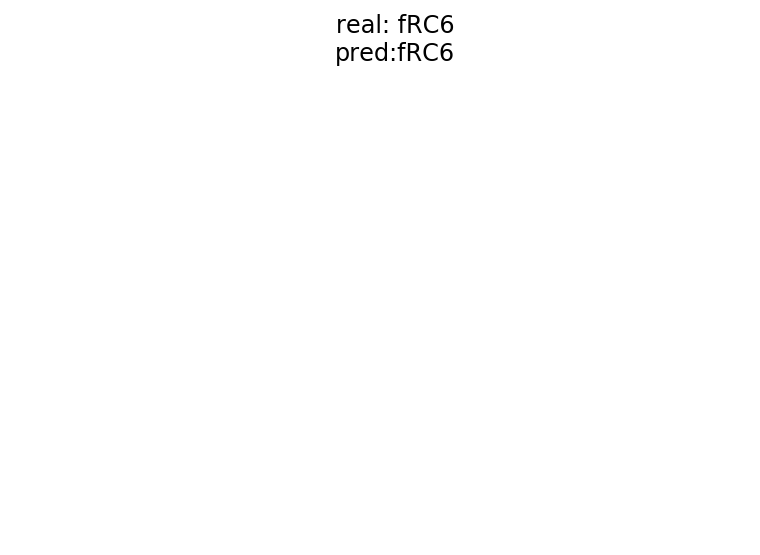

In [34]:

genImg1=gen(1, True)
#X, y = next(genfile("4297.png"))
X, y = next(genImg1)

y_pred = model.predict(X)

plt.title('real: %s\npred:%s'%(decode(y,0 ), decode(y_pred, 0)))
#plt.imshow(X[0], cmap='gray')
plt.axis('off')

# 计算模型总体准确率

In [32]:
from tqdm import tqdm
def evaluate(model, batch_num=20):
    batch_acc = 0
    generator = gen()
    for i in tqdm(range(batch_num)):
        X, y = next(generator)
        y_pred = model.predict(X)
        batch_acc += np.mean(list(map(np.array_equal, np.argmax(y, axis=2).T, np.argmax(y_pred, axis=2).T)))
    return batch_acc / batch_num

evaluate(model)

100%|██████████████████████████████████████████| 20/20 [00:06<00:00,  2.89it/s]


0.9671875

# 保存模型

In [29]:
model.save('cnn_num_upper_somelower_conn2d_3_5.h5')